# Binary Image Classification Deep Learning Model for [PROJECT NAME] Using TensorFlow Version 1
### David Lowe
### November 23, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The [PROJECT NAME] dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: [Sample Paragraph - The dataset contains 500 rendered images of various species of horses in different poses in multiple locations. It also includes 527 rendered images of humans in various poses and locations. Emphasis has been taken to ensure the diversity of humans, and to that end, there are both men and women as well as different ethnic groups present in the training set. The validation set adds six different figures of varying gender, race, and pose to ensure the breadth of data.]

ANALYSIS: [Sample Paragraph - The performance of the baseline model achieved an accuracy score of 94.35% after 20 epochs using the training dataset. After tuning the hyperparameters, the best model processed the validation dataset with an accuracy score of 98.52%. Furthermore, the final model processed the test dataset with an accuracy measurement of 73.80%.]

CONCLUSION: In this iteration, the TensorFlow CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Binary image classification with numerical attributes

Dataset Reference: [http://www.laurencemoroney.com/horses-or-humans-dataset/]

One potential source of performance benchmarks: [http://www.laurencemoroney.com/horses-or-humans-dataset/]

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# # Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# # Retrieve GPU configuration information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve memory configuration information from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# # Direct Colab to use TensorFlow v2
# %tensorflow_version 2.x

In [5]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


## 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
seedNum = 888

In [7]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import boto3
import zipfile
from datetime import datetime
from dotenv import load_dotenv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set various default modeling parameters
default_loss = 'binary_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.GlorotUniform(seed=seedNum)
default_epoch = 5
default_batch = 16
default_image_size = (300, 300)
input_image_shape = (300, 300, 3)

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 0
TensorFlow version: 2.3.0


In [9]:
# Set up the parent directory location for loading the dotenv files
# useColab = True
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = True
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [12]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [13]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [14]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [15]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/
!rm horse-or-human-training.zip
!rm horse-or-human-validation.zip

In [16]:
!wget https://dainesanalytics.com/datasets/laurencemoroney-horses-humans-dataset/horse-or-human-training.zip

--2020-11-14 00:48:45--  https://dainesanalytics.com/datasets/laurencemoroney-horses-humans-dataset/horse-or-human-training.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.225.143.95, 13.225.143.78, 13.225.143.129, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.225.143.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human-training.zip’

horse-or-human-trai 100%[===================>] 142.65M  11.9MB/s    in 14s     

2020-11-14 00:49:00 (9.93 MB/s) - ‘horse-or-human-training.zip’ saved [149574867/149574867]



In [17]:
!wget https://dainesanalytics.com/datasets/laurencemoroney-horses-humans-dataset/horse-or-human-validation.zip

--2020-11-14 00:49:02--  https://dainesanalytics.com/datasets/laurencemoroney-horses-humans-dataset/horse-or-human-validation.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.225.143.78, 13.225.143.9, 13.225.143.95, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.225.143.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘horse-or-human-validation.zip’

horse-or-human-vali 100%[===================>]  10.95M  7.36MB/s    in 1.5s    

2020-11-14 00:49:04 (7.36 MB/s) - ‘horse-or-human-validation.zip’ saved [11480187/11480187]



In [18]:
staging_dir = 'staging/'
!mkdir staging/

In [19]:
local_zip = 'horse-or-human-training.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(staging_dir+'training/')
local_zip = 'horse-or-human-validation.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(staging_dir+'validation/')
zip_ref.close()

In [20]:
training_dir = 'staging/training/'
validation_dir = 'staging/validation/'
classA_name = 'horses'
classB_name = 'humans'

In [21]:
# Brief listing of training image files for class A
training_classA_dir = os.path.join(training_dir, classA_name)
training_classA_files = os.listdir(training_classA_dir)
print('Number of training images for', classA_name, ':', len(os.listdir(training_classA_dir)))
print('Training samples for', classA_name, ':', training_classA_files[:10])

# Brief listing of training image files for class B
training_classB_dir = os.path.join(training_dir, classB_name)
training_classB_files = os.listdir(training_classB_dir)
print('Number of training images for', classB_name, ':', len(os.listdir(training_classB_dir)))
print('Training samples for', classB_name, ':', training_classB_files[:10])

Number of training images for horses : 500
Training samples for horses : ['horse01-0.png', 'horse01-1.png', 'horse01-2.png', 'horse01-3.png', 'horse01-4.png', 'horse01-5.png', 'horse01-6.png', 'horse01-7.png', 'horse01-8.png', 'horse01-9.png']
Number of training images for humans : 527
Training samples for humans : ['human01-00.png', 'human01-01.png', 'human01-02.png', 'human01-03.png', 'human01-04.png', 'human01-05.png', 'human01-06.png', 'human01-07.png', 'human01-08.png', 'human01-09.png']


In [22]:
# Brief listing of validation image files for class A
validation_classA_dir = os.path.join(validation_dir, classA_name)
validation_classA_files = os.listdir(validation_classA_dir)
print('Number of validation images for', classA_name, ':', len(os.listdir(validation_classA_dir)))
print('Validation samples for', classA_name, ':', validation_classA_files[:10])

# Brief listing of validation image files for class B
validation_classB_dir = os.path.join(validation_dir, classB_name)
validation_classB_files = os.listdir(validation_classB_dir)
print('Number of validation images for', classB_name, ':', len(os.listdir(validation_classB_dir)))
print('Validation samples for', classB_name, ':', validation_classB_files[:10])

Number of validation images for horses : 128
Validation samples for horses : ['horse1-000.png', 'horse1-105.png', 'horse1-122.png', 'horse1-127.png', 'horse1-170.png', 'horse1-204.png', 'horse1-224.png', 'horse1-241.png', 'horse1-264.png', 'horse1-276.png']
Number of validation images for humans : 128
Validation samples for humans : ['valhuman01-00.png', 'valhuman01-01.png', 'valhuman01-02.png', 'valhuman01-03.png', 'valhuman01-04.png', 'valhuman01-05.png', 'valhuman01-06.png', 'valhuman01-07.png', 'valhuman01-08.png', 'valhuman01-09.png']


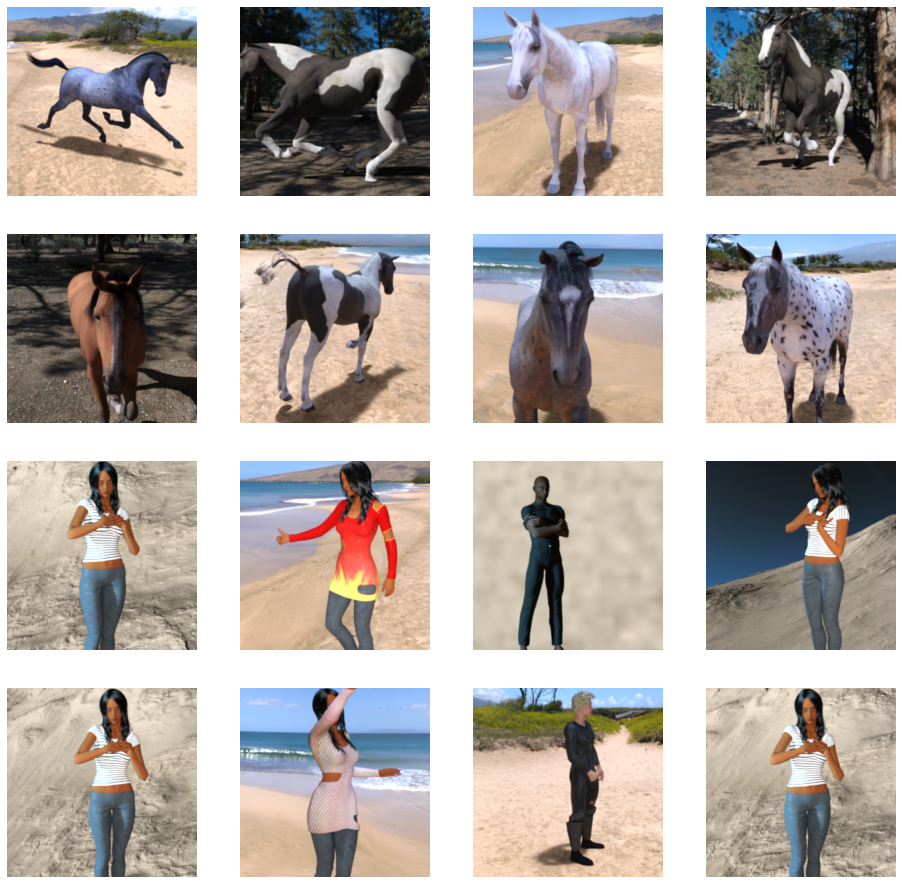

In [23]:
# Plot some training images from the dataset
nrows = 4
ncols = 4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

reset_random(seedNum)
number_elements = ncols * 2
random_training_classA = random.sample(training_classA_files, number_elements)
random_training_classB = random.sample(training_classB_files, number_elements)
next_classA = [os.path.join(training_classA_dir, fname) for fname in random_training_classA]
next_classB = [os.path.join(training_classB_dir, fname) for fname in random_training_classB]

for i, img_path in enumerate(next_classA + next_classB):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [24]:
print('Loading and pre-processing the training images...')
training_datagen = ImageDataGenerator(rescale=1/255)
# training_datagen = ImageDataGenerator(rescale=1./255,
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#     zoom_range = 0.1, # Randomly zoom image 
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip=False,  # randomly flip images
#     vertical_flip=False,  # randomly flip images
#     fill_mode='nearest')
training_generator = training_datagen.flow_from_directory(training_dir, target_size=default_image_size, batch_size=default_batch, class_mode='binary')
print('Number of image batches per epoch of modeling:', len(training_generator))

Loading and pre-processing the training images...
Found 1027 images belonging to 2 classes.
Number of image batches per epoch of modeling: 33


In [25]:
print('Loading and pre-processing the validation images...')
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=default_image_size, batch_size=default_batch, class_mode='binary')
print('Number of image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the validation images...
Found 256 images belonging to 2 classes.
Number of image batches per epoch of modeling: 8


In [26]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [27]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [28]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
#         if metric == train_loss:
#             plt.ylim([0, plt.ylim()[1]])
#         else:
#             plt.ylim([0.5, 1.1])
        plt.legend()

In [31]:
# Define the baseline model for benchmarking
def create_nn_model(conv1_filters=48, conv2_filters=32, conv3_filters=16, conv1_dropout=0.25, conv2_dropout=0.25, conv3_dropout=0.25,
                    dense_nodes=512, dense_dropout=0.5, n_inputs=input_image_shape, opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model = keras.Sequential([
        # This is the first convolution
        keras.layers.Conv2D(conv1_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param, input_shape=n_inputs),
        keras.layers.Dropout(conv1_dropout),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2,  padding='same'),
        # This is the second convolution
        keras.layers.Conv2D(conv2_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(conv2_dropout),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2,  padding='same'),
        # This is the third convolution
        keras.layers.Conv2D(conv3_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(conv3_dropout),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2,  padding='same'),
        # Flatten the results to feed into a DNN
        # This is the last neuron hidden layer
        keras.layers.Flatten(),
        keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(dense_dropout),
        keras.layers.Dense(1, activation='sigmoid', kernel_initializer=init_param)
    ])
    nn_model.compile(loss=default_loss, optimizer=opt_param, metrics=default_metrics)
    return nn_model

In [32]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
reset_random(seedNum)
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(
    training_generator,
    steps_per_epoch=len(training_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=default_epoch,
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/5
33/33 [==============================] - 247s 7s/step - loss: 1.8861 - accuracy: 0.9046 - val_loss: 11.2280 - val_accuracy: 0.5000
Epoch 2/5
33/33 [==============================] - 247s 7s/step - loss: 0.2297 - accuracy: 0.9659 - val_loss: 19.3064 - val_accuracy: 0.5000
Epoch 3/5
33/33 [==============================] - 247s 7s/step - loss: 0.0824 - accuracy: 0.9873 - val_loss: 33.8456 - val_accuracy: 0.5000
Epoch 4/5
33/33 [==============================] - 247s 7s/step - loss: 4.3268e-04 - accuracy: 1.0000 - val_loss: 40.5950 - val_accuracy: 0.5000
Epoch 5/5
33/33 [==============================] - 249s 8s/step - loss: 0.0775 - accuracy: 0.9932 - val_loss: 25.6206 - val_accuracy: 0.5000
Total time for model fitting: 0:21:21.352044


In [33]:
nn_model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 48)      1344      
_________________________________________________________________
dropout (Dropout)            (None, 300, 300, 48)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 300, 48)      192       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 48)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      13856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      1

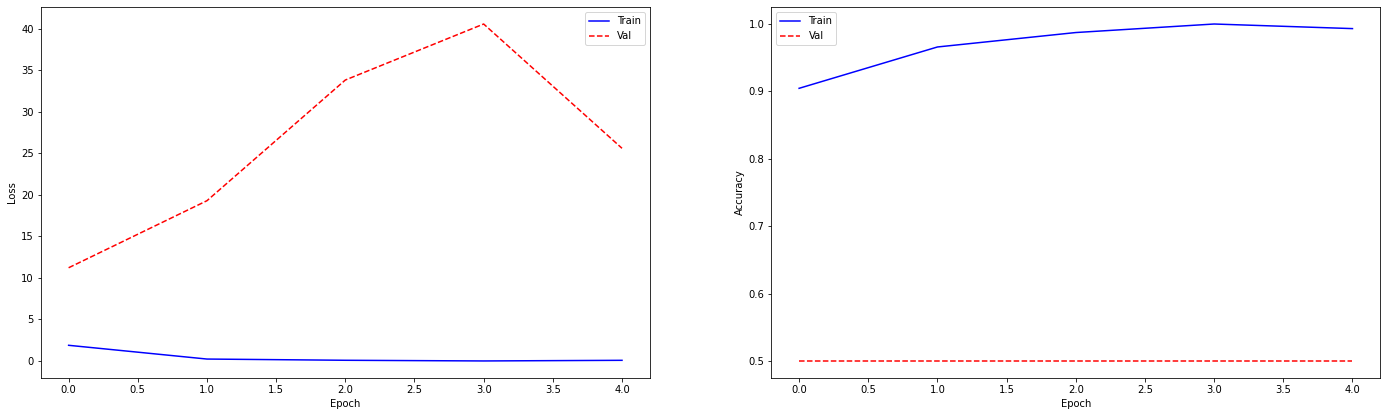

In [34]:
plot_metrics(nn_model_history)

In [35]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [36]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## 4.a) Alternate Model One

In [37]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
reset_random(seedNum)
nn_model_1 = create_nn_model(conv1_filters=96, conv2_filters=64, conv3_filters=32, conv1_dropout=0.25, conv2_dropout=0.25, conv3_dropout=0.25, dense_nodes=512, dense_dropout=0.5)
nn_model_history = nn_model_1.fit(
    training_generator,
    steps_per_epoch=len(training_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=default_epoch,
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/5
33/33 [==============================] - 475s 14s/step - loss: 5.7274 - accuracy: 0.8481 - val_loss: 15.3013 - val_accuracy: 0.5000
Epoch 2/5
33/33 [==============================] - 476s 14s/step - loss: 0.6815 - accuracy: 0.9747 - val_loss: 2.9749 - val_accuracy: 0.8320
Epoch 3/5
33/33 [==============================] - 476s 14s/step - loss: 0.1413 - accuracy: 0.9932 - val_loss: 37.6375 - val_accuracy: 0.5117
Epoch 4/5
33/33 [==============================] - 475s 14s/step - loss: 0.0739 - accuracy: 0.9951 - val_loss: 60.6134 - val_accuracy: 0.5000
Epoch 5/5
33/33 [==============================] - 475s 14s/step - loss: 0.0349 - accuracy: 0.9961 - val_loss: 78.0761 - val_accuracy: 0.5000
Total time for model fitting: 0:40:56.475185


In [38]:
nn_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 300, 300, 96)      2688      
_________________________________________________________________
dropout_4 (Dropout)          (None, 300, 300, 96)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 300, 300, 96)      384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 150, 150, 96)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 64)      55360     
_________________________________________________________________
dropout_5 (Dropout)          (None, 150, 150, 64)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 150, 150, 64)     

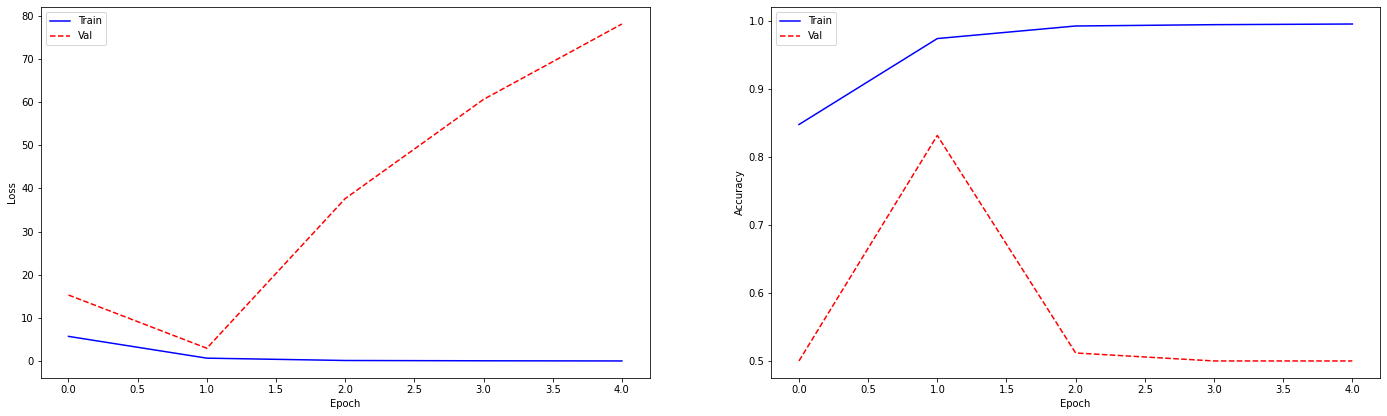

In [39]:
plot_metrics(nn_model_history)

In [40]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [41]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [42]:
final_model = nn_model_1

# Display a summary of the final model
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 300, 300, 96)      2688      
_________________________________________________________________
dropout_4 (Dropout)          (None, 300, 300, 96)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 300, 300, 96)      384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 150, 150, 96)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 64)      55360     
_________________________________________________________________
dropout_5 (Dropout)          (None, 150, 150, 64)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 150, 150, 64)     

In [43]:
# Print the labels used for the modeling
print(validation_generator.class_indices)

{'horses': 0, 'humans': 1}


In [44]:
final_model.evaluate(validation_generator, verbose=1)

8/8 [==============================] - 14s 2s/step - loss: 78.0761 - accuracy: 0.5000


[78.07611846923828, 0.5]

In [45]:
test_pred = final_model.predict(validation_generator)
test_predictions = (test_pred > 0.5).astype('int').ravel()
test_original = validation_generator.labels
print(test_predictions)
print(test_original)
# print('Accuracy Score:', accuracy_score(test_original, test_predictions))
# print(confusion_matrix(test_original, test_predictions))
# print(classification_report(test_original, test_predictions))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [46]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [47]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 1:04:48.611732
